In [17]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from plotting import plot_utils, load_fits, summary_plots
from utils import roi_utils, default_paths
from feature_extraction import gabor_feature_extractor


#### Load model fits

In [19]:
subjects = np.arange(1,9)

n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'

trial_subsets = ['both_animate-inanimate', 'animate', 'inanimate',\
                 'both_small-large', 'small', 'large',\
                 'both_indoor-outdoor', 'indoor', 'outdoor']

n_trial_subsets = len(trial_subsets)

out_all = []
for ti, ts in enumerate(trial_subsets):
    
    if ts=='all_trials':
        ft = fitting_type
    else:
        ft ='%s_%s'%(fitting_type, ts)

    out = [load_fits.load_fit_results(subject=ss, fitting_type=ft, \
                                      n_from_end=0, \
                                  verbose=False) \
           for ss in subjects]
    out_all.append(out)
    
out = out_all

fig_save_folder=None

roi_def = roi_utils.multi_subject_roi_def(subjects, \
                                          remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[0][si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

#### Get info about the Gabor feature space

In [3]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### threshold voxels within groups by R2

groups are one semantic axis at a time. 

For instance, group 1 is [balanced indoor outdoor/just outdoor/just indoor], each w same number of trials.
Always use the same set of voxels when comparing within a group, so threshold them each here.

In [4]:

subsets2group = [[0,1,2], [3,4,5], [6,7,8]];
group_names=[trial_subsets[ti].split('both_')[1] for ti in [0,3,6]]
n_groups = len(subsets2group)


group_inds = [np.where([ti in group for group in subsets2group])[0][0] \
    for ti in range(n_trial_subsets)]


voxels_use = [ [[] for ss in subjects] for ai in range(n_groups)]

min_trials = 10;

n_prfs = 1456
n_trn_trials = np.zeros((n_subjects, n_prfs, n_groups))
n_val_trials = np.zeros((n_subjects, n_prfs, n_groups))
n_out_trials = np.zeros((n_subjects, n_prfs, n_groups))

for si, subject in enumerate(subjects):

    for gi, group in enumerate(subsets2group):
               
        # using all voxels with R2 above threshold for all fits in this group
        # make matrix [n_voxels x 3]
        val_r2_alltrials = np.array([out[xi][si]['val_r2'][:,0] for xi in group])
        
        voxel_prf_inds = out[group[0]][si]['best_params'][5][:,0]
        
        abv_thresh = np.all(val_r2_alltrials>0.01, axis=0)  
        
        # load the file that has the sub-sampled trial order in it.
        # use this to get the exact number of trials that were used, so that 
        # we can make sure it was not too small.
        # there is one of these files for each sub-sampled order in each "group"
        # but can just load one since they have the same num trials.
        subset = trial_subsets[group[0]]
        # subset = 'both_'+subset.split('both_')[1]
        fn2load = os.path.join(default_paths.stim_labels_root, 'resampled_trial_orders',\
                       'S%d_trial_resamp_order_%s.npy'%\
                               (subject, subset)) 
        if si==0:
            print(group)
            print(np.array(trial_subsets)[np.array(group)])       
            print('loading balanced trial order (pre-computed) from %s'%fn2load)
            
        trials = np.load(fn2load, allow_pickle=True).item()
    
        # based on counts, there are some pRFs that we can't use because they 
        # don't have enough trials. this only affects face & building
        prfs_exclude = (trials['min_counts_trn']<min_trials) | \
                       (trials['min_counts_val']<min_trials) | \
                       (trials['min_counts_out']<min_trials)
        
        # so we have to exclude any voxels having those pRFs from the analysis.
        voxels_exclude = prfs_exclude[voxel_prf_inds]
        print(np.mean(voxels_exclude)) # should be small
        
        voxels_use[gi][si] = abv_thresh & ~voxels_exclude 
        
#         assert(np.all(trials['min_counts_trn']>=min_trials))
#         assert(np.all(trials['min_counts_val']>=min_trials))
#         assert(np.all(trials['min_counts_out']>=min_trials))
        
        n_trn_trials[si,:,gi] = trials['min_counts_trn']
        n_val_trials[si,:,gi] = trials['min_counts_val']
        n_out_trials[si,:,gi] = trials['min_counts_out']


[0, 1, 2]
['both_animate-inanimate' 'animate' 'inanimate']
loading balanced trial order (pre-computed) from /user_data/mmhender/nsd/labels/resampled_trial_orders/S1_trial_resamp_order_both_animate-inanimate.npy
0.0
[3, 4, 5]
['both_small-large' 'small' 'large']
loading balanced trial order (pre-computed) from /user_data/mmhender/nsd/labels/resampled_trial_orders/S1_trial_resamp_order_both_small-large.npy
0.0
[6, 7, 8]
['both_indoor-outdoor' 'indoor' 'outdoor']
loading balanced trial order (pre-computed) from /user_data/mmhender/nsd/labels/resampled_trial_orders/S1_trial_resamp_order_both_indoor-outdoor.npy
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [5]:
colors = np.concatenate([np.flipud(cm.Reds(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,5)))[1:3,:]])

colors_categ = np.concatenate([np.flipud(cm.Reds(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,6)))[2:3,:]])

#### organizing the feature sensitivity values for each voxel

matrix [n_voxels_total x n_channels x n_trial_subsets]

In [6]:
feature_corr = np.moveaxis(np.array([np.concatenate([out[fi][si]['corr_each_feature'] \
                                for si in range(n_subjects)], axis=0) \
                for fi in range(n_trial_subsets)]), [0,1,2], [2,0,1])

n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf, n_trial_subsets], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1,:], [1,n_ori,1])==mean_orient_corr, axis=1)
for gi, group in enumerate(subsets2group): 
    voxels_using_thisgroup =  np.concatenate(voxels_use[gi], axis=0)
    for gg in group:
        # assert(not np.any(is_constant[voxels_using_thisgroup,gg]))
        preferred_ori_corr[~voxels_using_thisgroup,gg] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1,:], [1,n_sf,1])==mean_sf_corr, axis=1)
for gi, group in enumerate(subsets2group): 
    voxels_using_thisgroup =  np.concatenate(voxels_use[gi], axis=0)
    for gg in group:
        # assert(not np.any(is_constant[voxels_using_thisgroup,gg]))
        preferred_sf_corr[~voxels_using_thisgroup,gg] = np.nan


In [7]:
avg_resp_profiles = np.zeros((n_subjects, n_rois, n_ori, n_sf, n_groups, 3))

for si in range(n_subjects):
    for ri in range(n_rois):      
        
        for gi, group in enumerate(subsets2group):
            
            inds_this_roi = roi_def.get_indices(ri) & \
                    np.concatenate(voxels_use[gi], axis=0) & \
                    (subject_inds==si)   
            
            for ti, ts in enumerate(group):
                
                avg_resp_profiles[si,ri,:,:,gi,ti] = np.mean(allcorr_reshaped[inds_this_roi,:,:,ts], axis=0)
                
                

['both_animate-inanimate', 'animate', 'inanimate']
/user_data/mmhender/image_stats_gabor/figures/Featuretuning_2d_trialsubsets_animate-inanimate.pdf
['both_small-large', 'small', 'large']
/user_data/mmhender/image_stats_gabor/figures/Featuretuning_2d_trialsubsets_small-large.pdf
['both_indoor-outdoor', 'indoor', 'outdoor']
/user_data/mmhender/image_stats_gabor/figures/Featuretuning_2d_trialsubsets_indoor-outdoor.pdf


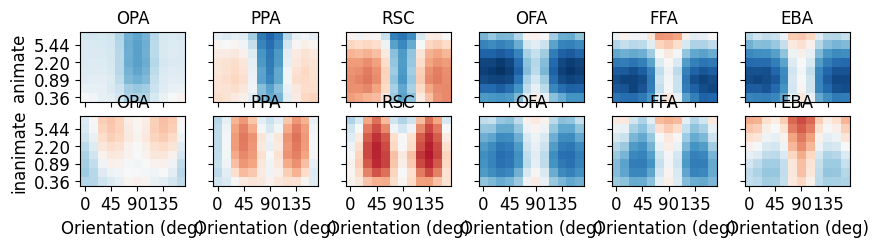

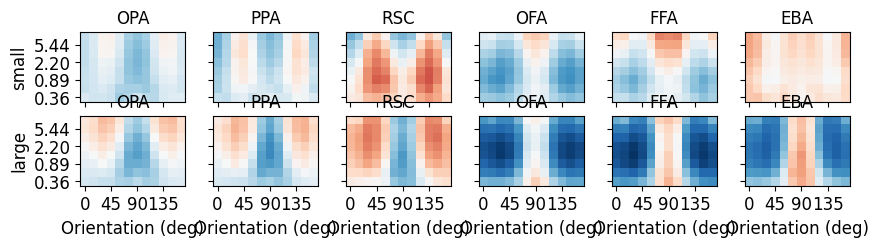

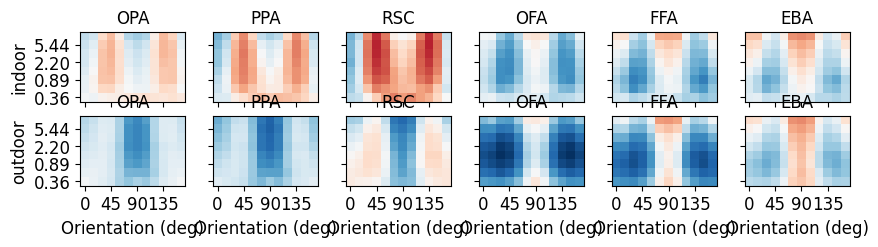

In [8]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

# rois_plot = [6,7,8,11]
rois_plot = [6,7,8,9,10,11]

npx = 2;
# npx = 3;
# npy = 4;
npy = len(rois_plot)


clims = [-0.6, 0.6]

for gi in [0,1,2]:
# for gi in range(n_groups):
    
    plt.figure(figsize=(10,2))
    
    pi=0
    
    group = subsets2group[gi]
    subset_names = [trial_subsets[gg] for gg in group]
    name = subset_names[0].split('both_')[1]
    print(subset_names)
   
    for ti in [1,2]:
    # for ti in range(3):

        for ri, rr in enumerate(rois_plot):
        # for rr in range(n_rois):

            pi+=1
            plt.subplot(npx,npy,pi)


            vals = np.mean(avg_resp_profiles[:,rr,:,:,gi,ti], axis=0)


            plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

            if ti==2:
                plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
                plt.xlabel('Orientation (deg)')

            else:
                plt.xticks(np.arange(0,12,3)+0.5,[])

            sf_ticks = sf_unique[[0,2,4,6]].round(2)
            if (ri==0):
                plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
                # plt.ylabel('S.F. (cyc/deg)')
                plt.ylabel(subset_names[ti])
            else:
                plt.yticks(np.array([0,2,4,6])+0.5,[])
            plt.axis('square')
            plt.xlim([0,12])
            plt.ylim([0,8])

            plt.title('%s'%(roi_names[rr]))

    # plt.suptitle(name)

    fn2save = os.path.join(default_paths.fig_path, 'Featuretuning_2d_trialsubsets_%s.pdf'%name)
    print(fn2save)
    plt.savefig(fn2save)

In [10]:
colors_outdoor = np.flipud(cm.Greens(np.linspace(0,1,3))[1:3,:])
colors_outdoor = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_outdoor], axis=0)

colors_animacy = np.flipud(cm.Reds(np.linspace(0,1,5))[[1,3],:])
colors_animacy = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_animacy], axis=0)

colors_size = np.flipud(cm.Blues(np.linspace(0,1,3))[1:3,:])
colors_size = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_size], axis=0)

colors_face = np.flipud(cm.Purples(np.linspace(0,1,3))[1:3,:])
colors_face = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_face], axis=0)

colors_categ = [colors_face, colors_animacy, colors_size, colors_outdoor]

In [ ]:
vals.shape

(12, 12, 8)

In [ ]:
is_constant.shape

(150842, 12)

In [ ]:
preferred_sf_corr.shape

(150842, 12)

In [ ]:
voxels_use_facebuilding = np.concatenate(voxels_use[0], axis=0)

In [ ]:
np.any(is_constant[voxels_use_facebuilding,0:3], axis=0)

array([False, False, False])

#### How similar is sensitivity profile across different categories?
Compare levels of each semantic axis - indoor only vs outdoor only, etc

In [ ]:
corr_between_methods = np.zeros((n_voxels, n_groups))
compare_names = [[] for gi in range(n_groups)]
for gi, group in enumerate(subsets2group):
    ti1 = group[1]; ti2 = group[2];
    print([ti1, ti2])
    compare_names[gi] = '%s vs. %s'%(trial_subsets[ti1], trial_subsets[ti2])
    
    corr_between_methods[:,gi] = np.array([np.corrcoef(feature_corr[vv,:,ti1], \
                                                 feature_corr[vv,:,ti2])[0,1] \
                                 for vv in range(n_voxels)])

[1, 2]
[4, 5]
[7, 8]


In [11]:
corr_between_methods = np.zeros((n_voxels, n_groups*2))
compare_names = []
xx = -1

for gi, group in enumerate(subsets2group):
    
    xx+=1
    ti1 = group[0]; ti2 = group[1];
    print([ti1, ti2])
    compare_names += ['%s vs. %s'%(trial_subsets[ti1], trial_subsets[ti2])]
    print(compare_names[-1])
    
    corr_between_methods[:,xx] = np.array([np.corrcoef(feature_corr[vv,:,ti1], \
                                                 feature_corr[vv,:,ti2])[0,1] \
                                 for vv in range(n_voxels)])
    
    xx+=1
    ti1 = group[0]; ti2 = group[2];
    print([ti1, ti2])
    compare_names += ['%s vs. %s'%(trial_subsets[ti1], trial_subsets[ti2])]
    print(compare_names[-1])
    
    corr_between_methods[:,xx] = np.array([np.corrcoef(feature_corr[vv,:,ti1], \
                                                 feature_corr[vv,:,ti2])[0,1] \
                                 for vv in range(n_voxels)])

[0, 1]
both_animate-inanimate vs. animate
[0, 2]
both_animate-inanimate vs. inanimate
[3, 4]
both_small-large vs. small
[3, 5]
both_small-large vs. large
[6, 7]
both_indoor-outdoor vs. indoor
[6, 8]
both_indoor-outdoor vs. outdoor


In [12]:
# Averaging these values within ROI

n_vox_each_subj = [out[0][si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)


avg_corr_bw_methods = np.zeros((n_rois, n_subjects, n_groups*2))
for rr in range(n_rois):
    for ss in range(n_subjects):
        xx=-1
        for gi in range(n_groups):
            inds_this_roi = roi_def.get_indices(rr) \
                & (subject_inds==ss) \
                & np.concatenate(voxels_use[gi], axis=0)
           
            
            xx+=1
            # print([gi, xx])
            vals = corr_between_methods[inds_this_roi,xx]
            assert(not np.any(np.isnan(vals)))
            avg_corr_bw_methods[rr,ss,xx] = \
                np.mean(vals, axis=0)
            
            xx+=1
            # print([gi, xx])
            vals = corr_between_methods[inds_this_roi,xx]
            assert(not np.any(np.isnan(vals)))
            avg_corr_bw_methods[rr,ss,xx] = \
                np.mean(vals, axis=0)

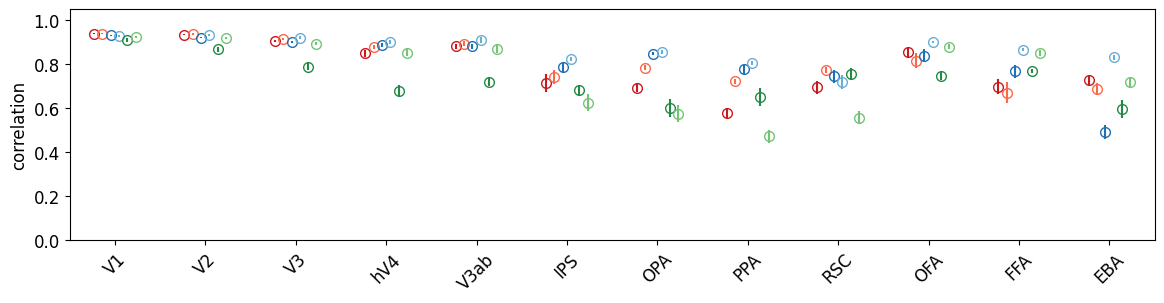

In [15]:
colors = np.concatenate([np.flipud(cm.Reds(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,5)))[1:3,:]])

mean_vals = np.mean(avg_corr_bw_methods, axis=1)
sem_vals = np.std(avg_corr_bw_methods, axis=1)/np.sqrt(n_subjects)

xoffsets = np.linspace(-0.23,0.23,n_groups*2)

plt.rcParams['pdf.fonttype']=42
plt.figure(figsize=(14,3))
for gg in range(n_groups*2):
    
    xpos = np.arange(n_rois)+xoffsets[gg]
    
    plt.plot(xpos, mean_vals[:,gg], 'o', color=colors[gg,:],markerfacecolor='none',markersize=7)

    plt.errorbar(xpos, mean_vals[:,gg], sem_vals[:,gg], \
                 color=colors[gg,:], linestyle='none')
plt.xticks(np.arange(0, n_rois), roi_names, rotation=45)
plt.ylabel('correlation')
plt.ylim([0.0, 1.05])
plt.xlim([-0.5, n_rois-1+0.5])

fn2save = os.path.join(default_paths.fig_path, 'Similarity_featuretuning_acrosscategory_circles.pdf')
plt.savefig(fn2save)